# Study Design Capstone
This is an exploration of a dataset from moving violations in Chicago. The data lists the location of the traffic cameras and number of violations they have given per day for the last few years. I will look at a few aspects of the data and propose an experiment that could be conducted to test the value of the cameras.

Dataset is from 
https://www.kaggle.com/chicago/chicago-red-light-and-speed-camera-data

In [1]:
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
import os
os.getcwd()

'C:\\Users\\Chris\\Documents\\thinkful\\thinkful_notes'

In [3]:
#unzip file
from zipfile import ZipFile 
file_name = r"C:\Users\Chris\Documents\thinkful\data_sets\chicago-red-light-and-speed-camera-data.zip"
  
# open file and unzip 
with ZipFile(file_name, 'r') as zip:    #readmode
    zip.printdir() 
    zip.extractall(path=r'C:\Users\Chris\Documents\thinkful\data_sets\speed_cam') 

File Name                                             Modified             Size
socrata_metadata_speed-camera-violations.json  2019-06-06 22:50:52        17371
socrata_metadata_red-light-camera-locations.json 2019-06-06 22:50:52        10604
speed-camera-locations.csv                     2019-06-06 22:50:52        42073
red-light-camera-locations.csv                 2019-06-06 22:50:52        34534
speed-camera-violations.csv                    2019-06-06 22:50:52     53258913
red-light-camera-violations.csv                2019-06-06 22:50:54    141887527
socrata_metadata_speed-camera-locations.json   2019-06-06 22:50:58        10424
socrata_metadata_red-light-camera-violations.json 2019-06-06 22:50:58        19172


In [4]:
df = pd.read_csv(r'C:\Users\Chris\Documents\thinkful\data_sets\speed_cam\speed-camera-violations.csv')

In [5]:
df.tail()

,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
188620,7518 S VINCENNES,CHI063,2014-07-01T00:00:00.000,124,1.175649e+06,1.855003e+06,41.757497,-87.631833,"{'longitude': '-87.63183332832696', 'latitude'...",17.0,21554.0,67.0,495.0,32.0
188621,7738 S WESTERN,CHI065,2014-07-01T00:00:00.000,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188622,7739 S WESTERN,CHI064,2014-07-01T00:00:00.000,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188623,7826 S PULASKI,CHI072,2014-07-01T00:00:00.000,27,1.151041e+06,1.852282e+06,41.750546,-87.722093,"{'longitude': '-87.72209265589272', 'latitude'...",23.0,4300.0,69.0,571.0,30.0
188624,7833 S PULASKI,CHI071,2014-07-01T00:00:00.000,120,1.151122e+06,1.852224e+06,41.750385,-87.721795,"{'longitude': '-87.72179453872008', 'latitude'...",6.0,4300.0,69.0,571.0,30.0


In [6]:
#rename to simpler names
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()

In [7]:
#remove records without location data
df.dropna(axis=0, subset=['zip_codes'], inplace=True)

In [8]:
df.dtypes

address                        object
camera_id                      object
violation_date                 object
violations                      int64
x_coordinate                  float64
y_coordinate                  float64
latitude                      float64
longitude                     float64
location                       object
historical_wards_2003-2015    float64
zip_codes                     float64
community_areas               float64
census_tracts                 float64
wards                         float64
dtype: object

In [9]:
#get column of just dates in date format
df['violation_dt'] = df['violation_date'].apply(lambda x: x[:10])
df['violation_dt'] = pd.to_datetime(df['violation_dt'])

In [10]:
#change wards to ints for cleaner display
df.wards = df.wards.astype(int)

In [11]:
#group data by date for view of it over time
by_date_df = df.groupby('violation_dt')['violations', 'violation_dt'].agg({sum})

In [12]:
by_date_df.tail()

,violations
,sum
violation_dt,
2019-05-19,2238
2019-05-20,2822
2019-05-21,2380
2019-05-22,3101
2019-05-23,3230


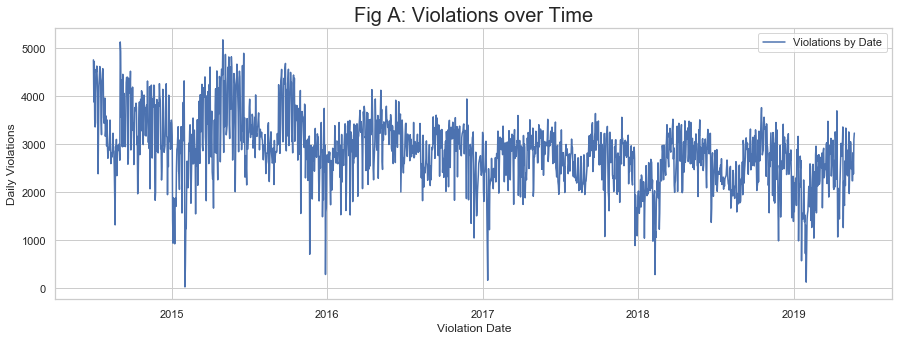

In [13]:
#avoid Futurewarning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("whitegrid")
fig_f, ax_f = plt.subplots()
#plot by date
ax_f = sns.lineplot(x=by_date_df.index, y=by_date_df.iloc[:,0], label='Violations by Date', palette='muted')
ax_f.set_title("Fig A: Violations over Time", size=20)
ax_f.set_xlabel('Violation Date')
ax_f.set_ylabel('Daily Violations');

In [14]:
#by ward aggregates
ward_df = df.groupby(['wards'])['violations'].agg([sum, 'count', np.mean, np.std])
ward_df.columns = ['violations', 'cameras', 'mean_vio_per_cam', 'vio_std']
ward_df.sort_values(axis=0, by='violations', inplace=True, ascending=False)
ward_df.head()

,violations,cameras,mean_vio_per_cam,vio_std
wards,,,,
38,622837,7735,80.521913,78.503492
14,325309,6048,53.787864,45.060393
4,309846,6819,45.438627,44.494447
43,282628,5106,55.352135,69.310013
47,243581,6726,36.214838,44.386234


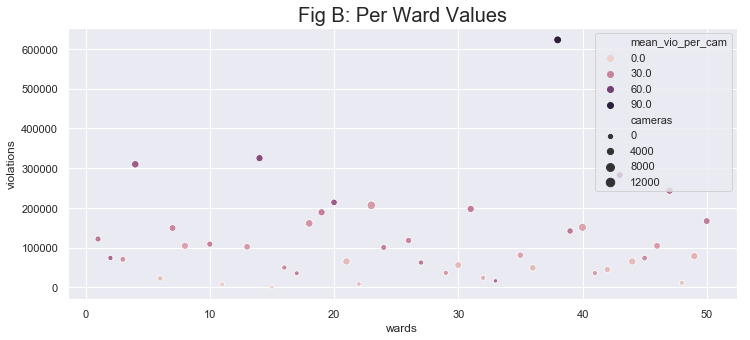

In [15]:
#plot
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style("darkgrid")
fig_w, ax_w = plt.subplots()
ax_w = sns.scatterplot(data=ward_df, x=ward_df.index, y='violations', hue='mean_vio_per_cam', 
                    size='cameras')
ax_w.legend(loc='upper right')
ax_w.set_title('Fig B: Per Ward Values', size=20); 

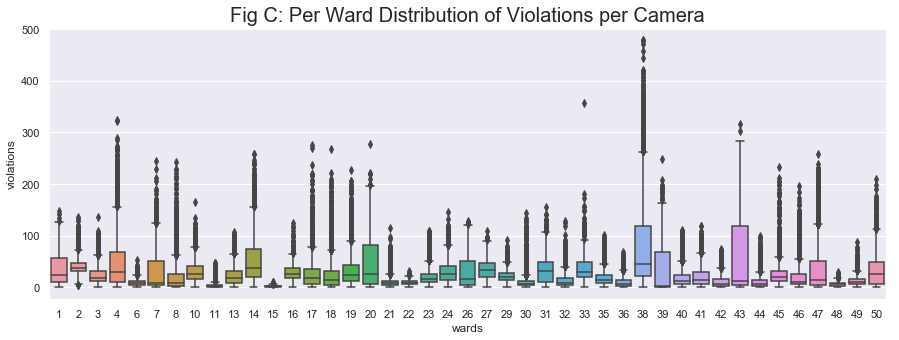

In [16]:
#boxplot
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("darkgrid")
#fig_w, ax_w = plt.subplots()
ax_w = sns.boxplot(x='wards', y='violations', data=df)
#ax_w.legend(loc='upper right')
ax_w.set_title('Fig C: Per Ward Distribution of Violations per Camera', size=20);

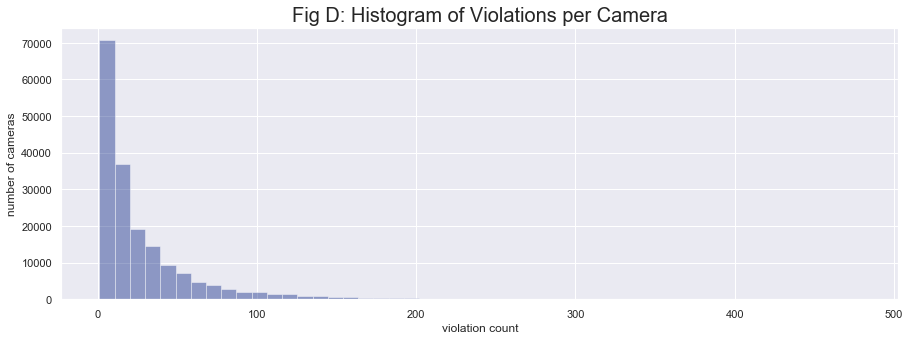

In [17]:
#histogram of all frequency
sns.set_palette('dark')
ax_h = sns.distplot(df.violations, kde=False)
ax_h.set_title("Fig D: Histogram of Violations per Camera", size=20)
ax_h.set(xlabel='violation count', ylabel='number of cameras');

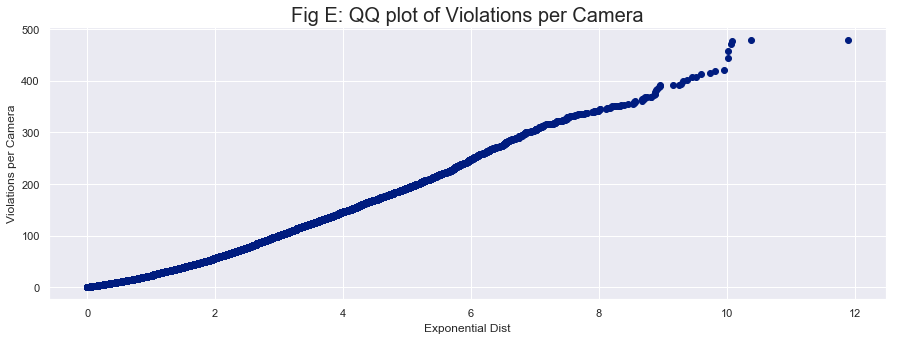

In [18]:
##qq plot - matches exponential distribution
xp_rand = np.random.exponential(size=df.violations.size)
vios_sort = df.violations.sort_values(ascending=True).values
xp_rand = np.sort(xp_rand)
#plot data
figqq = plt.figure()
axqq = figqq.add_subplot(111)
figqq = plt.plot(xp_rand, vios_sort, "o") 
axqq.set_xlabel('Exponential Dist')
axqq.set_ylabel('Violations per Camera')
axqq.set_title('Fig E: QQ plot of Violations per Camera', size=20)
plt.show();

In [19]:
#check that cameras are located on major streets
df2 = pd.DataFrame()
df2['fulladd'] = df.address.str.rsplit()
df3 = pd.DataFrame(df2.fulladd.values.tolist())
df3.columns = ['numb', 'dir', 'street', 'type', 'unk']
df3.groupby(['dir', 'street'])[['numb']].count().head(10)

numb
dir street        
E   63RD       690
    71ST       134
    75TH      1766
    87TH       886
    95TH      6572
    ILLINOIS  1246
    MORGAN    1782
N   ASHLAND   9743
    BROADWAY  2445
    CENTRAL   1702

## Analysis

### Hypothesis:
My hypothesis is that traffic cameras which give out moving violations cause increased compliance with traffic laws, which in turn causes fewer traffic accidents proximate to the camera compared to city-wide. 

#### Problem: 
The impact of the traffic cameras which send out automated speeding violations could be studied for their effect on traffic safety. The goal of the cameras and traffic laws they enforce is both to be revenue source, but also to improve the safety of the people living in the city.

### Roll-out plan and Implementation
#### Experiment:
We will pick a selection of intersections from our dataset as set A. These would be picked at random. We would next find intersections with similar traffic levels to the intersections picked, set B. One way we might do that is to look at the addresses of the cameras. The cameras are located on major avenues and roads in Chicago, so once the control intersections are selected, we could move 3 or 4 blocks along the road to find our set B intersections. 

We will randomly select the cameras to move. While biasing the selection to pick cameras issuing high number of violations (and thus busier and/or more dangerous intersections), it would also risk affecting the results, as well as incurring higher cost (both in terms of violation fees and potential safety benefits.)

With the two sets of intersections, we will conduct a cross-over study of the two sets of intersections. First, we will measure the existing safety of both sets of intersection. Then, the cameras will be moved from set A intersections to set B. We will then measure the change in violations at each location, and the change in number of police reports of traffic accidents on the block where the cameras are, both set A & set B.

There would be several advantages to this study design. 
* Avoided cost for additional camera equipment.
* Partial avoidance of the problem that violations vary over the course of the year (see fig A; there appear to be spring and fall peaks, and a January low.) and that there may be reasons roads become safer or less safe, e.g. a blizzard would cause an increase in accidents, but this would have a net 0 effect since it would be increasing accidents in one set's control period while increase accidents in the other set's treatment period.
* If it turns out that the intersections the cameras are moved to are less or more busy than the original ones, this would be a way to reduce the impact of that on the results. 
* We would also get data on better or worse locations for cameras. 


### Evaluation Plan
The sets will have the treatment periods (with camera) combined and control periods (no camera) combined, and the control and treatment period compared. Ideally the data could be collected for a year or more, but initial conclusions could likely be drawn after a month or two.  We may want to ignore the initial data. The first few weeks, people may not see that cameras have been added or removed, and it may take time for drivers to adjust. The mostly likely way to change the cameras would be for a crew to do them sequentially, so the data on what date the change occurs will be needed, and the treatment and control periods will be individual for each camera, though mostly likely with great overlap.

We would also be interested in the number of violations at the old and new intersections, and if traffic accidents are correlated with high numbers of traffic violations. 

#### Primary success metric:
The result will be analyzed by comparing year-over-year traffic accident reports for the combined sets A & B; the null hypothesis is that the combined average traffic accident reports will not change between the treatment and control period. If there is a significant (p<.05) reduction in the mean y-o-y change in accident reports on the blocks where cameras are moved we will reject the null and consider the cameras a success. 

#### Secondary metrics:
We may want to separately compare the before and after on the intersections where the cameras are removed, and the before and after on the intersections where they were added. Since cameras generate income, the cost-benefit trade-off can be ignored.
